In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [3]:
from glob import glob
import json
import matplotlib.pyplot as plt
import os
from pathlib import Path
import sys
import torch
from torch.optim.adamw import AdamW
from torch.optim.adam import Adam

sys.path.append(os.path.expanduser('..'))

from environments.sac_tracking_env import Environment
from plot import tracking_interface
from data_prep import load
from models import ResNet3D, ResidualBlock3D, ConvNet
from memory.buffer import PrioritizedReplayBuffer
from solvers import sac

DEVICE = 'cuda:0'
dtype = torch.float32

In [3]:
# image directory
# img_dir = "/home/brysongray/data/neurotrack_data/simulated_neurons/neuromorpho/neuromorpho_with_artifacts/"
# img_dir = "/home/brysongray/data/neurotrack_data/simulated_neurons/de-novo/3d_with_artifacts_b-0/"
img_dir = "/home/brysongray/data/neurotrack_data/simulated_neurons/de-novo/straight_no_artifacts/"

# instantiate environment

env = Environment(img_dir,
                radius=17,
                step_size=2.0,
                step_width=3.0,
                alpha=1.0,
                beta=0.2,
                repeat_starts=False)

In [6]:
plt.close('all')

reward: tensor([7.9388])
terminated: False


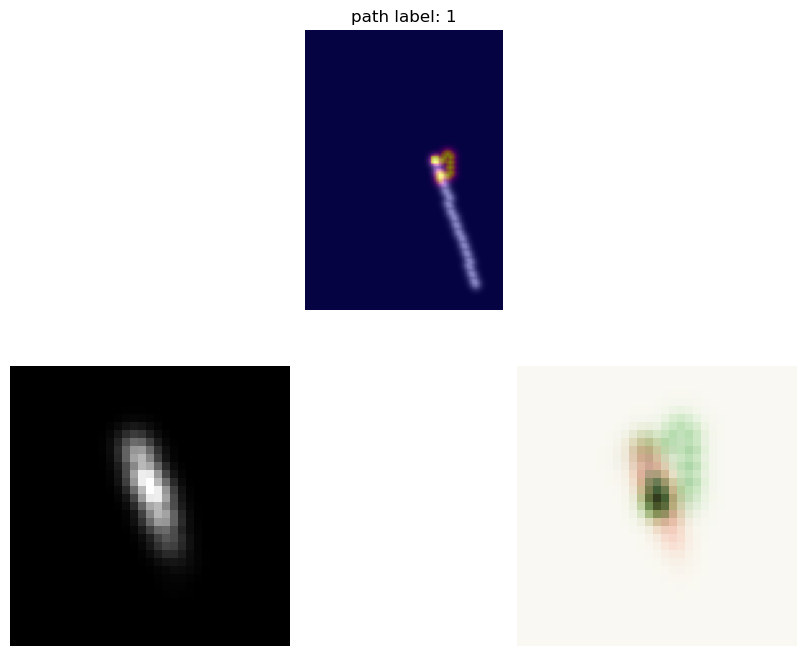

In [8]:
tracking_interface.manual_step(env)

In [8]:
env.img_files[env.img_idx]

'/nafs/dtward/bryson/data/simulated_neurons/neuromorpho_with_artifacts/150304_2_3_d'

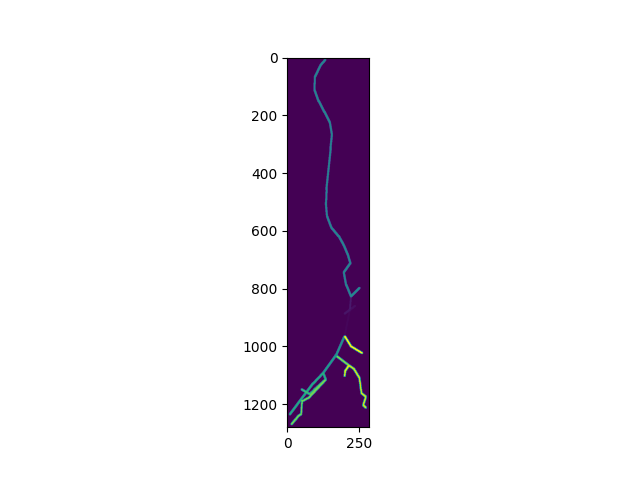

In [6]:
labels = env.section_labels.data[0]

plt.imshow(labels.amax(0))

In [4]:
config = '/home/brysongray/neurotrack/configs/train_sac_neuromorpho.json'
# config = '/home/brysongray/neurotrack/configs/train_sac_simulated.json'

with open(config) as f:
    params = json.load(f)
    
img_path = params["img_path"]
outdir = params["outdir"]
name = params["name"]
step_size = params["step_size"] if "step_size" in params else 1.0
step_width = params["step_width"] if "step_width" in params else 1.0
batch_size = params["batchsize"] if "batchsize" in params else 256
tau = params["tau"] if "tau" in params else 0.005
gamma = params["gamma"] if "gamma" in params else 0.99
lr = params["lr"] if "lr" in params else 0.001
alpha = params["alpha"] if "alpha" in params else 1.0
beta = params["beta"] if "beta" in params else 1e-3
friction = params["friction"] if "friction" in params else 1e-4
n_episodes = params["n_episodes"] if "n_episodes" in params else 100
init_temperature = params["init_temperature"] if "init_temperature" in params else 0.005
target_entropy = params["target_entropy"] if "target_entropy" in params else 0.0
repeat_starts = params["repeat_starts"] if "repeat_starts" in params else True
section_masking = params["section_masking"] if "section_masking" in params else False
patch_radius = 17

if "classifier_weights" in params:
    classifier_path = params["classifier_weights"]
    classifier_state_dict = torch.load(classifier_path)#, weights_only=True)
    classifier = ResNet3D(ResidualBlock3D, [3, 4, 6, 3], num_classes=1)
    classifier = classifier.to(device=DEVICE, dtype=dtype)
    classifier.load_state_dict(classifier_state_dict)
    classifier.eval()
else:
    classifier = None

env = Environment(img_path,
                radius=patch_radius,
                step_size=step_size,
                step_width=step_width,
                max_len=1000,
                alpha=alpha,
                beta=beta,
                friction=friction,
                repeat_starts=repeat_starts,
                section_masking=section_masking,
                classifier=classifier)

in_channels = 4
input_size = 2*patch_radius+1
init_temperature = 0.005
actor = ConvNet(chin=in_channels, chout=4)
actor = actor.to(device=DEVICE,dtype=dtype)

Q1 = ConvNet(chin=in_channels+3,chout=1)
Q1 = Q1.to(device=DEVICE,dtype=dtype)
Q2 = ConvNet(chin=in_channels+3,chout=1)
Q2 = Q2.to(device=DEVICE,dtype=dtype)
Q1_target = ConvNet(chin=7,chout=1)
Q1_target = Q1_target.to(device=DEVICE,dtype=dtype)
Q2_target = ConvNet(chin=7,chout=1)
Q2_target = Q2_target.to(device=DEVICE,dtype=dtype)

if "sac_weights" in params:
    sac_path = params["sac_weights"]
    state_dicts = torch.load(sac_path)#, weights_only=True)
    actor.load_state_dict(state_dicts["policy_state_dict"])
    Q1.load_state_dict(state_dicts["Q1_state_dict"])
    Q2.load_state_dict(state_dicts["Q2_state_dict"])

Q1_target.load_state_dict(Q1.state_dict())
Q2_target.load_state_dict(Q2.state_dict())

log_alpha = torch.log(torch.tensor(init_temperature).to(DEVICE))
log_alpha.requires_grad = True
Q1_optimizer = AdamW(Q1.parameters(), lr=lr)
Q2_optimizer = AdamW(Q2.parameters(), lr=lr)
actor_optimizer = AdamW(actor.parameters(), lr=lr)
log_alpha_optimizer = Adam([log_alpha], lr=lr)

memory = PrioritizedReplayBuffer(100000, obs_shape=(in_channels,input_size,input_size,input_size), action_shape=(3,), alpha=0.8)

In [5]:
env.img_files

['/home/brysongray/data/neurotrack_data/simulated_neurons/neuromorpho/neuromorpho_with_artifacts/Tracetest_N360_semicircle_Map2Tau_79_semi-auto_18',
 '/home/brysongray/data/neurotrack_data/simulated_neurons/neuromorpho/neuromorpho_with_artifacts/DG_Adulthood_Control_F_Animal01_Trace891',
 '/home/brysongray/data/neurotrack_data/simulated_neurons/neuromorpho/neuromorpho_with_artifacts/8-STRESS_2w_Female_HIP_7',
 '/home/brysongray/data/neurotrack_data/simulated_neurons/neuromorpho/neuromorpho_with_artifacts/35dpi_ipsi_infra_06',
 '/home/brysongray/data/neurotrack_data/simulated_neurons/neuromorpho/neuromorpho_with_artifacts/NNE1L',
 '/home/brysongray/data/neurotrack_data/simulated_neurons/neuromorpho/neuromorpho_with_artifacts/Bub_9-13_c1',
 '/home/brysongray/data/neurotrack_data/simulated_neurons/neuromorpho/neuromorpho_with_artifacts/Cell_134_MPD_12_FT_10_XYZ_Sorted-swc_N3DFix-swc_4',
 '/home/brysongray/data/neurotrack_data/simulated_neurons/neuromorpho/neuromorpho_with_artifacts/CeA_As

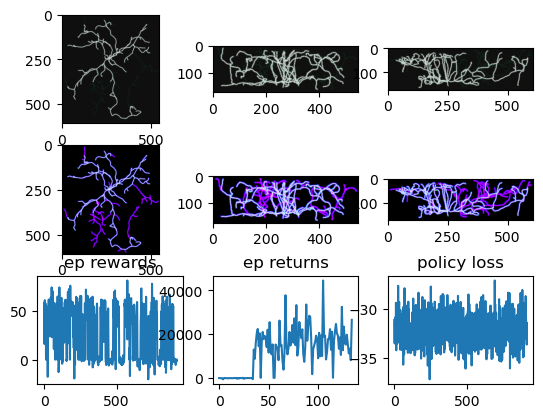

num branches: 101


  7%|▋         | 135/2000 [5:31:02<94:17:34, 182.01s/it]

image: CN_Development_P22_F_Animal03_Trace009


: 

In [5]:
sac.train(env, actor, Q1, Q2, Q1_target, Q2_target, log_alpha,
        actor_optimizer, Q1_optimizer, Q2_optimizer, log_alpha_optimizer,
        memory, target_entropy, batch_size, gamma, tau, outdir, name,
        show_states=True, save_snapshots=False, update_after=256,
        updates_per_step=1, update_every=1, n_episodes=n_episodes, n_trials=1)

In [7]:
import cProfile

with cProfile.Profile() as pr:
    sac.train(env, actor, Q1, Q2, Q1_target, Q2_target, log_alpha,
        actor_optimizer, Q1_optimizer, Q2_optimizer, log_alpha_optimizer,
        memory, target_entropy, batch_size, gamma, tau, outdir, name,
        show_states=False, save_snapshots=False, update_after=256,
        updates_per_step=1, update_every=1, n_episodes=n_episodes, n_trials=1)
    
    # Sort stats by cumulative time
    pr.print_stats(sort='tottime')

100%|██████████| 4/4 [00:43<00:00, 10.87s/it]

         1258878 function calls (1108464 primitive calls) in 43.487 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    22591   30.927    0.001   30.927    0.001 {method 'read' of '_io.BufferedReader' objects}
18900/11384    8.471    0.000    8.356    0.001 {built-in method zlib.decompress}
18900/12102    0.796    0.000    0.742    0.000 tifffile.py:9445(func)
      108    0.590    0.005    0.590    0.005 {built-in method torch.cat}
     3600    0.357    0.000    0.357    0.000 {built-in method torch.conv3d}
22110/8733    0.257    0.000  125.762    0.014 tifffile.py:15056(read_segments)
        8    0.177    0.022   42.465    5.308 sac_tracking_env.py:447(reset)
       41    0.153    0.004    0.242    0.006 {method 'poll' of 'select.epoll' objects}
        4    0.116    0.029   41.688   10.422 sac_tracking_env.py:215(__load_data)
      125    0.100    0.001    0.100    0.001 {built-in method torch.zeros}
     3600    0.094 

In [5]:
import cProfile

with cProfile.Profile() as pr:
    sac.train(env, actor, Q1, Q2, Q1_target, Q2_target, log_alpha,
        actor_optimizer, Q1_optimizer, Q2_optimizer, log_alpha_optimizer,
        memory, target_entropy, batch_size, gamma, tau, outdir, name,
        show_states=False, save_snapshots=False, update_after=256,
        updates_per_step=1, update_every=1, n_episodes=n_episodes, n_trials=1)
    
    # Sort stats by cumulative time
    pr.print_stats(sort='tottime')

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:34<00:00,  8.67s/it]

         765134 function calls (749240 primitive calls) in 34.694 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    14659   21.701    0.001   21.701    0.001 {method 'acquire' of '_thread.lock' objects}
       85    5.485    0.065    8.365    0.098 sac_tracking_env.py:319(step)
      385    1.104    0.003    1.904    0.005 image.py:162(crop)
       85    0.964    0.011    0.966    0.011 buffer.py:152(push)
       81    0.881    0.011    0.881    0.011 {built-in method cat}
      166    0.784    0.005    0.784    0.005 {built-in method ones}
     2628    0.594    0.000    0.594    0.000 {built-in method conv3d}
      304    0.470    0.002    0.470    0.002 {method 'clone' of 'torch._C._TensorBase' objects}
        8    0.469    0.059   24.230    3.029 sac_tracking_env.py:447(reset)
       93    0.281    0.003    0.281    0.003 {built-in method zeros}
        4    0.235    0.059   22.630    5.657 sac_tracking_env.py:215(__l

In [9]:
len(env.finished_paths)

33

In [10]:
print([len(f) for f in env.finished_paths])

[4, 4, 6, 10, 14, 3, 31, 16, 27, 16, 22, 20, 27, 35, 36, 67, 28, 21, 18, 41, 18, 14, 47, 71, 82, 36, 102, 88, 70, 20, 95, 21, 93]


In [5]:
swc_dir = "/home/brysongray/data/neurotrack_data/simulated_neurons/neuromorpho/swc_trees"
swc_files = [f for x in os.walk(swc_dir) for f in glob(os.path.join(x[0], "*.swc"))]
swc_files[0]

'/home/brysongray/data/neurotrack_data/simulated_neurons/neuromorpho/swc_trees/neuromorpho/mehder/CNG version/Rasha-CA1-Exp-April-2016-right-slide-55-secion-1.CNG.swc'